In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def wrangle(csv_path,
            drop_item_types=("REF","STR_SUPPLIES","DUNNAGE"),
            item_type_alias=("TYPE","ITEMCATEGORY","CATEGORY"),
            month_alias=("MO",),
            year_alias=("YR",),
            yearmonth_alias=("YEAR_MONTH",),
            sales_alias={
                "RETAILSALES":"RETAIL_SALES","RETAIL_AMT":"RETAIL_SALES",
                "WAREHOUSESALES":"WAREHOUSE_SALES","WH_SALES":"WAREHOUSE_SALES",
                "TRANSFERS":"RETAIL_TRANSFERS"
            }):
    # 1) Lettura fissando il separatore a virgola
    df = df = pd.read_csv(csv_path, sep=";", low_memory=False)
           
    # 2) Standardizza nomi colonna
    df.columns = [c.strip().upper().replace(" ","_") for c in df.columns]

    # 3) Mappa alias noti
    if "ITEM_TYPE" not in df.columns:
        for alt in item_type_alias:
            if alt in df.columns:
                df.rename(columns={alt:"ITEM_TYPE"}, inplace=True)
                break

    for k,v in sales_alias.items():
        if k in df.columns and v not in df.columns:
            df.rename(columns={k:v}, inplace=True)

    if "YEAR" not in df.columns:
        for ya in year_alias:
            if ya in df.columns:
                df["YEAR"] = df[ya]
                break
    if "MONTH" not in df.columns:
        for ma in month_alias:
            if ma in df.columns:
                df["MONTH"] = df[ma]
                break

    # 4) Ricostruisci YEAR/MONTH da YEAR_MONTH se mancano
    if ("YEAR" not in df.columns or "MONTH" not in df.columns):
        for yma in yearmonth_alias:
            if yma in df.columns:
                ym = df[yma].astype(str).str.strip()
                has_dash = ym.str.contains("-")
                if has_dash.any():
                    parts = ym.str.split("-", n=1, expand=True)
                    df["YEAR"] = pd.to_numeric(parts[0], errors="coerce")
                    df["MONTH"] = pd.to_numeric(parts[1], errors="coerce")
                else:
                    df["YEAR"] = pd.to_numeric(ym.str.slice(0,4), errors="coerce")
                    df["MONTH"] = pd.to_numeric(ym.str.slice(4,6), errors="coerce")
                break
    if "YEAR" not in df.columns or "MONTH" not in df.columns:
        raise RuntimeError("Colonne temporali non trovate: servono YEAR/MONTH o YEAR_MONTH.")

    # 5) Pulizia ITEM_TYPE e filtri
    if "ITEM_TYPE" in df.columns:
        df["ITEM_TYPE"] = df["ITEM_TYPE"].astype(str).str.upper().str.strip()
        if drop_item_types:
            df = df[~df["ITEM_TYPE"].isin([t.upper() for t in drop_item_types])]

    # 6) Coercizione numerica robusta (EU/US) per misure chiave
    def to_num(s):
        s = s.astype(str).str.strip()
        s = s.str.replace(r"[^0-9,.\-]", "", regex=True)
        both = s.str.contains(",") & s.str.contains(r"\.")
        # caso EU: 1.234,56 -> 1234.56
        s = s.where(~both, s.str.replace(r"\.", "", regex=True).str.replace(",", ".", regex=False))
        return pd.to_numeric(s, errors="coerce")

    for col in ("RETAIL_SALES","WAREHOUSE_SALES","RETAIL_TRANSFERS"):
        if col in df.columns and df[col].dtype == object:
            df[col] = to_num(df[col])

    # 7) Costruisci indice temporale e ordina
    df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce").astype("Int64")
    df["MONTH"] = pd.to_numeric(df["MONTH"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["YEAR","MONTH"])
    df["YEAR"] = df["YEAR"].astype(int)
    df["MONTH"] = df["MONTH"].astype(int)
    df["date"] = pd.to_datetime(df[["YEAR","MONTH"]].assign(DAY=1), errors="coerce")
    df = df.dropna(subset=["date"]).set_index("date").sort_index()

    # 8) TOTAL_SALES e dropna soft
    if "RETAIL_SALES" in df.columns:
        df["RETAIL_SALES"] = df["RETAIL_SALES"].fillna(0)
    if "WAREHOUSE_SALES" in df.columns:
        df["WAREHOUSE_SALES"] = df["WAREHOUSE_SALES"].fillna(0)
    if {"RETAIL_SALES","WAREHOUSE_SALES"}.issubset(df.columns):
        df["TOTAL_SALES"] = df["RETAIL_SALES"] + df["WAREHOUSE_SALES"]

    metrics = [c for c in ("RETAIL_SALES","WAREHOUSE_SALES","RETAIL_TRANSFERS","TOTAL_SALES") if c in df.columns]
    if metrics:
        df = df.dropna(how="all", subset=metrics)

    return df


In [3]:
df = wrangle("Case_1_Warehouse_and_Retail_Alcohol_Sales.csv")
df.head()

,YEAR,MONTH,SUPPLIER,ITEM_CODE,ITEM_DESCRIPTION,ITEM_TYPE,RETAIL_SALES,RETAIL_TRANSFERS,WAREHOUSE_SALES,TOTAL_SALES
date,,,,,,,,,,
2017-06-01,2017,6,LAPHAM SALES & MARKETING DBA LAPHAM,43046,ALTO DEL CARMEN PISCO - 750ML,LIQUOR,0.0,0.0,0.0,0.0
2017-06-01,2017,6,PRESTIGE BEVERAGE GROUP OF MD LLC,333879,ROBERTSON FRESHBURST S/BLC - 750ML,WINE,0.0,0.0,2.0,2.0
2017-06-01,2017,6,PUNTO VINO LLC,333872,LA CAPPUCCINA VERONA BIANCO - 20L,WINE,0.0,0.0,1.0,1.0
2017-06-01,2017,6,MONSIEUR TOUTON SELECTION,333870,VILLA JOLANDA ST VALENTINE I LOVE YOU SPUM - 1...,WINE,0.0,0.0,4.0,4.0
2017-06-01,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,333862,PENNER ASH RUBEO - 750ML,WINE,0.0,0.0,4.0,4.0


In [4]:
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Utility
def month_abbr(i): 
    return ["Gen","Feb","Mar","Apr","Mag","Giu","Lug","Ago","Set","Ott","Nov","Dic"][i-1]

def yoy(series):
    s = series.resample("MS").sum()
    return s.pct_change(12)*100

def savefig(name, folder="plots", dpi=200):
    Path(folder).mkdir(parents=True, exist_ok=True)
    plt.savefig(Path(folder)/f"{name}.png", dpi=dpi, bbox_inches="tight")

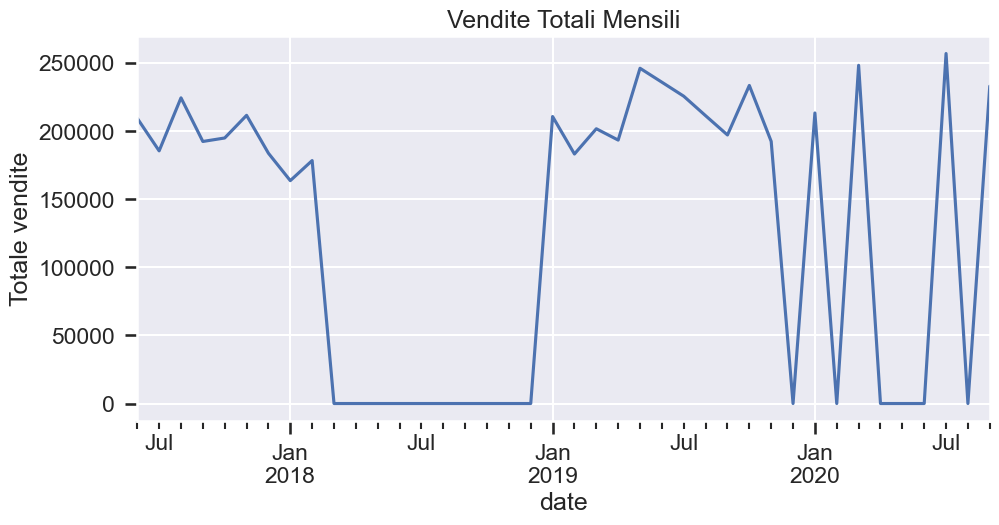

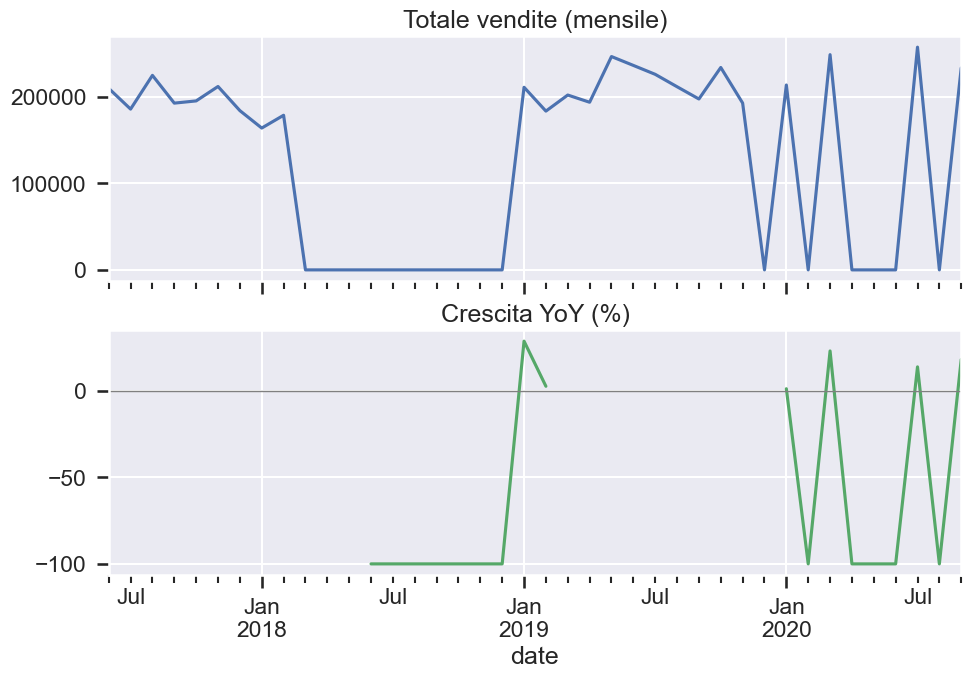

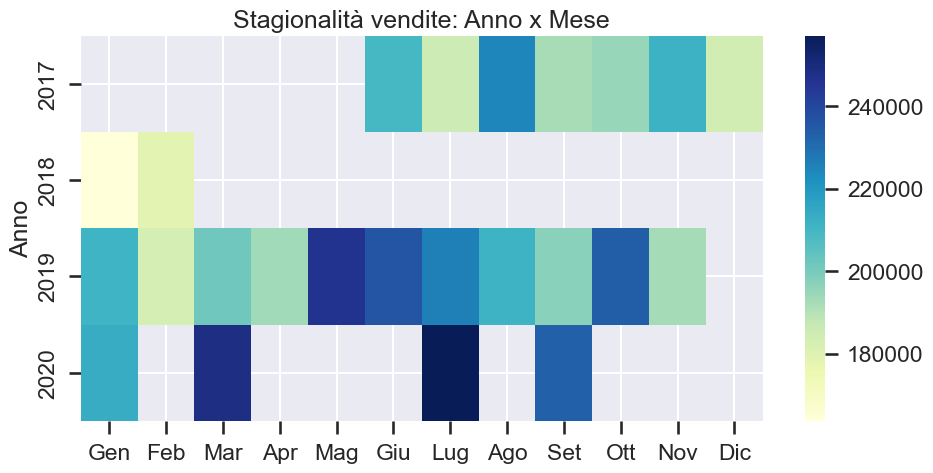

In [5]:
# Analisi #1: AS IS – Trend e stagionalità

# Trend totale
ts = df["TOTAL_SALES"].resample("MS").sum()
ax = ts.plot(figsize=(11,5), color="C0", title="Vendite Totali Mensili")
ax.set_ylabel("Totale vendite")
savefig("01_trend_totale")
plt.show()

# YoY
yoy_series = yoy(df["TOTAL_SALES"])
fig, ax = plt.subplots(2,1, figsize=(11,7), sharex=True)
ts.plot(ax=ax[0], color="C0"); ax[0].set_title("Totale vendite (mensile)")
yoy_series.plot(ax=ax[1], color="C1"); ax[1].axhline(0, color="gray", lw=1)
ax[1].set_title("Crescita YoY (%)")
savefig("02_trend_yoy")
plt.show()

# Heatmap stagionalità (Anno x Mese)
season = (df.groupby([df.index.year.rename("Anno"), df.index.month.rename("Mese")])["TOTAL_SALES"]
          .sum().unstack("Mese"))
season.columns = [month_abbr(m) for m in season.columns]
plt.figure(figsize=(11,5))
sns.heatmap(season, cmap="YlGnBu", annot=False)
plt.title("Stagionalità vendite: Anno x Mese")
savefig("03_heatmap_stagionalita")
plt.show()

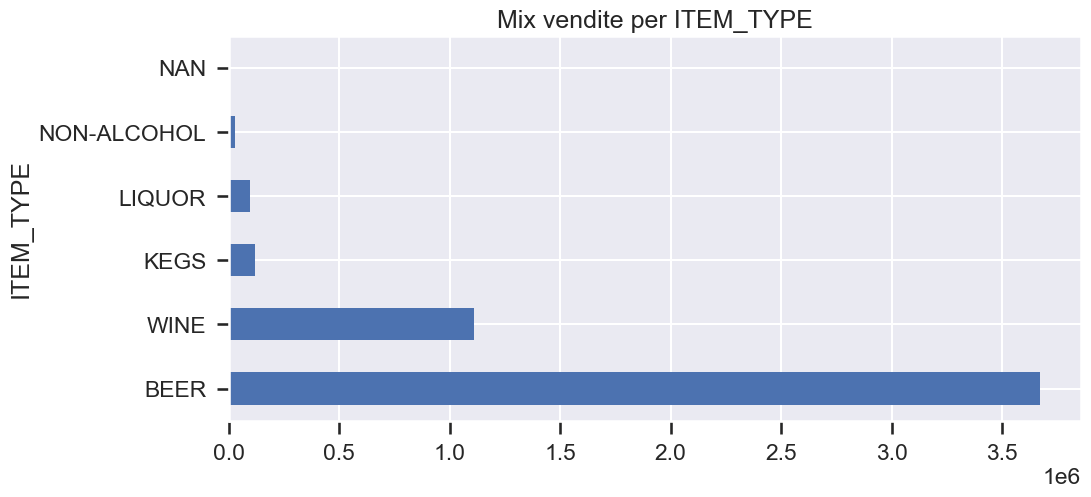

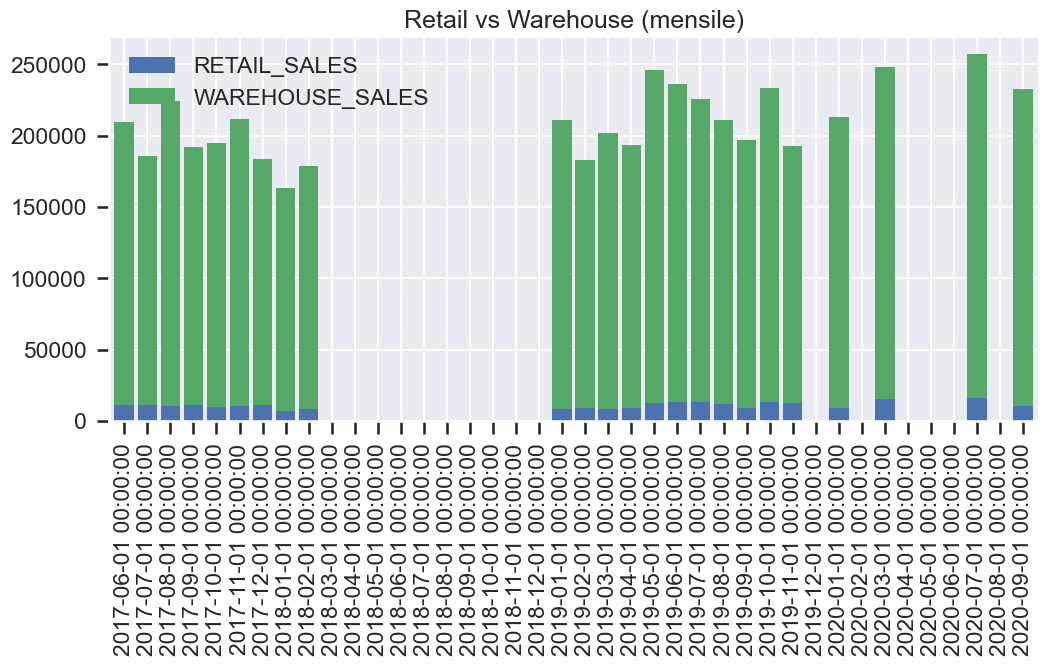

In [6]:
# Analisi #2: AS IS – Mix per categoria e canale

# Mix per ITEM_TYPE
if "ITEM_TYPE" in df.columns:
    mix = df.groupby("ITEM_TYPE")["TOTAL_SALES"].sum().sort_values(ascending=False)
    ax = mix.sort_values().plot(kind="barh", figsize=(11,5), color="C0")
    ax.set_title("Mix vendite per ITEM_TYPE")
    plt.gca().invert_yaxis()
    savefig("04_mix_item_type")
    plt.show()

# Canale: Retail vs Warehouse stacked
cols = [c for c in ["RETAIL_SALES","WAREHOUSE_SALES"] if c in df.columns]
if cols:
    chan = df.resample("MS")[cols].sum()
    ax = chan.plot(kind="bar", stacked=True, figsize=(12,5), title="Retail vs Warehouse (mensile)", width=0.85)
    ax.set_xlabel("")
    savefig("05_retail_vs_warehouse")
    plt.show()

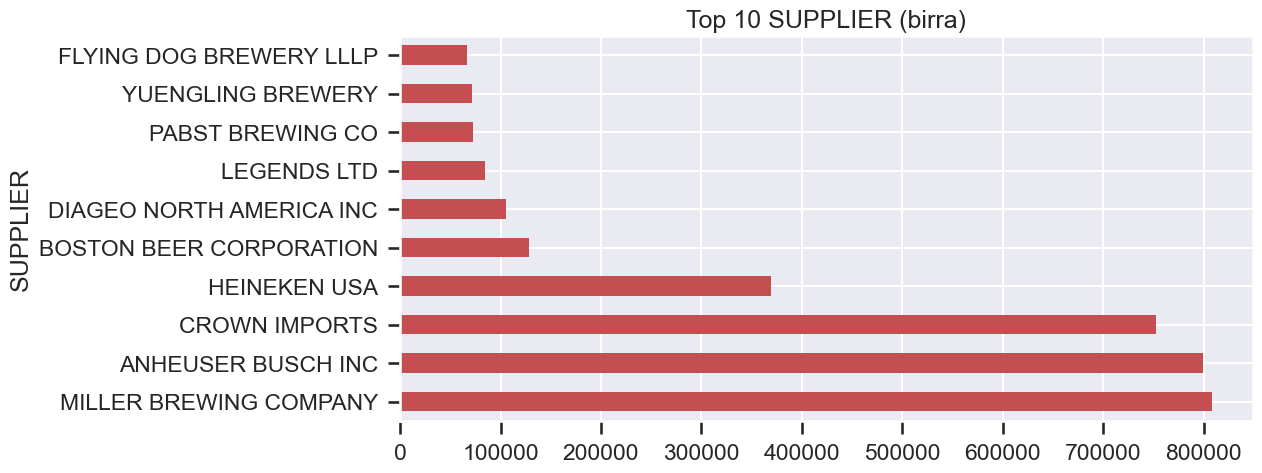

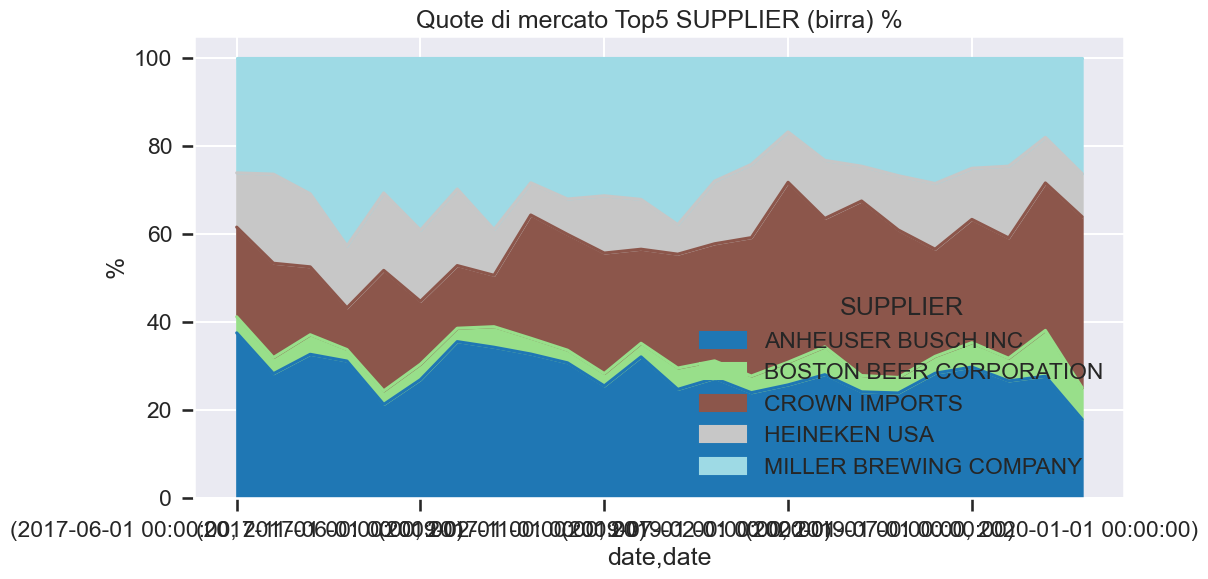

HHI birra (0-10000): 1523.3


In [7]:
# Analisi #3: Competitor – focus birra

# Filtro birra
if "ITEM_TYPE" in df.columns:
    beer = df[df["ITEM_TYPE"].str.contains("BEER", na=False)].copy()
else:
    beer = df.copy()

# Top 10 fornitori/brand/descrizione (in base a cosa c’è)
key = None
for k in ["SUPPLIER","BRAND","ITEM_DESCRIPTION"]:
    if k in beer.columns:
        key = k; break

if key:
    top = (beer.groupby(key)["TOTAL_SALES"].sum()
           .sort_values(ascending=False).head(10).sort_values())
    ax = top.plot(kind="barh", figsize=(11,5), color="C2", title=f"Top 10 {key} (birra)")
    plt.gca().invert_yaxis()
    savefig("06_top10_competitor_beer")
    plt.show()

# Quote di mercato nel tempo per Top5
if key:
    top5 = beer.groupby(key)["TOTAL_SALES"].sum().nlargest(5).index
    share = (beer[beer[key].isin(top5)]
             .groupby([pd.Grouper(freq="MS"), key])["TOTAL_SALES"].sum()
             .groupby(level=0).apply(lambda x: x / x.sum() * 100)
             .unstack(key))
    ax = share.plot.area(figsize=(12,6), cmap="tab20", title=f"Quote di mercato Top5 {key} (birra) %")
    ax.set_ylabel("%")
    savefig("07_market_share_top5_beer")
    plt.show()

# HHI (0-10000) per concentrazione
if key:
    market = beer.groupby(key)["TOTAL_SALES"].sum()
    shares = (market / market.sum()) * 100
    hhi = (shares**2).sum()
    print(f"HHI birra (0-10000): {hhi:.1f}")

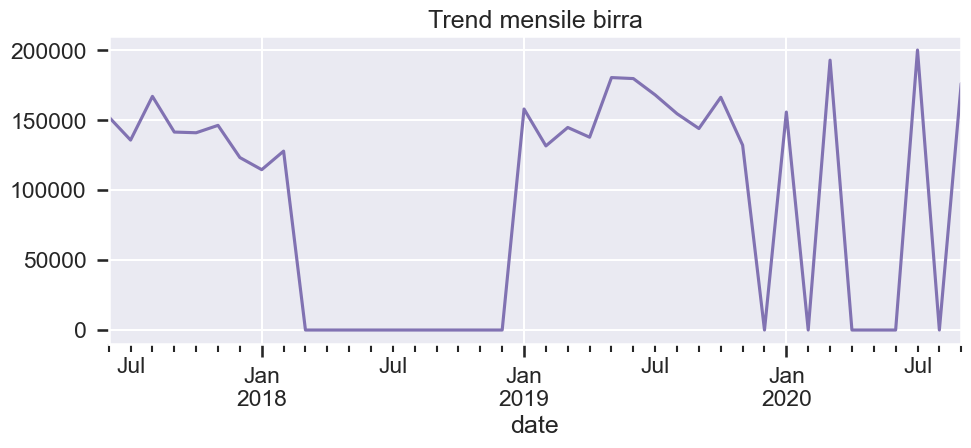

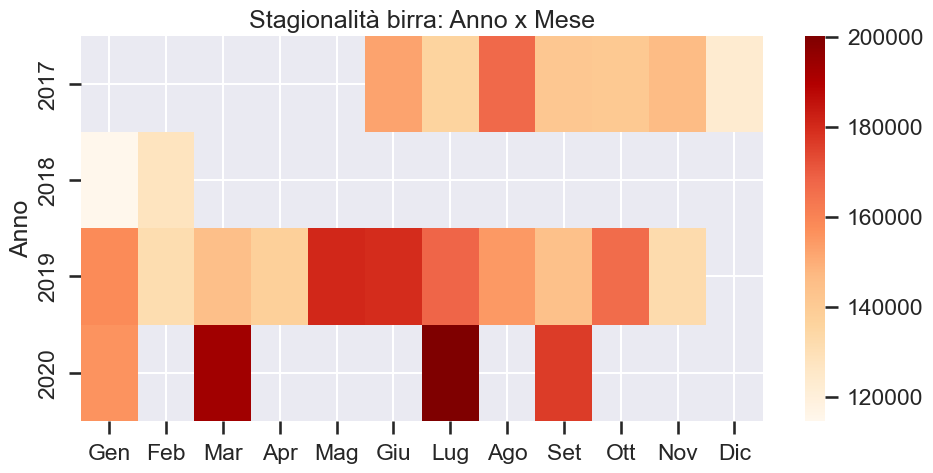

Mesi spike birra: ['2020-01', '2020-03', '2020-07', '2020-09']


In [8]:
# Analisi #4: Stagionalità birra e finestre promo

beer_ts = beer["TOTAL_SALES"].resample("MS").sum()
ax = beer_ts.plot(figsize=(11,4), color="C3", title="Trend mensile birra")
savefig("10_trend_beer")
plt.show()

beer_season = (beer.groupby([beer.index.year.rename("Anno"), beer.index.month.rename("Mese")])["TOTAL_SALES"]
               .sum().unstack("Mese"))
beer_season.columns = [month_abbr(m) for m in beer_season.columns]
plt.figure(figsize=(11,5))
sns.heatmap(beer_season, cmap="OrRd")
plt.title("Stagionalità birra: Anno x Mese")
savefig("11_heatmap_beer_season")
plt.show()

# Spike semplici (potenziali promo/eventi)
roll = beer_ts.rolling(3, center=True, min_periods=1).median()
spikes = (beer_ts > roll*1.25)
print("Mesi spike birra:", list(beer_ts[spikes].index.strftime("%Y-%m")))

In [9]:
# Analisi #5: Tabelle KPI per slide

kpi = {
    "Totale vendite": float(df["TOTAL_SALES"].sum()),
    "Crescita YoY ultima osservazione (%)": float(yoy(df["TOTAL_SALES"]).dropna().iloc[-1]) if yoy(df["TOTAL_SALES"]).notna().any() else np.nan
}
kpi_series = pd.Series(kpi).round(2)
print(kpi_series)

if "ITEM_TYPE" in df.columns:
    print(df.groupby("ITEM_TYPE")["TOTAL_SALES"].sum().sort_values(ascending=False).head(10).round(0))

if key:
    print(beer.groupby(key)["TOTAL_SALES"].sum().sort_values(ascending=False).head(10).round(0))

Totale vendite                          5029225.00
Crescita YoY ultima osservazione (%)         18.19
dtype: float64
ITEM_TYPE
BEER           3673156.0
WINE           1111949.0
KEGS            118431.0
LIQUOR           97095.0
NON-ALCOHOL      28593.0
NAN                  1.0
Name: TOTAL_SALES, dtype: float64
SUPPLIER
MILLER BREWING COMPANY      808485.0
ANHEUSER BUSCH INC          799873.0
CROWN IMPORTS               752569.0
HEINEKEN USA                369424.0
BOSTON BEER CORPORATION     128544.0
DIAGEO NORTH AMERICA INC    105674.0
LEGENDS LTD                  84507.0
PABST BREWING CO             72498.0
YUENGLING BREWERY            71809.0
FLYING DOG BREWERY LLLP      66820.0
Name: TOTAL_SALES, dtype: float64
